In [0]:
!pip install pandas
!pip install scikit-learn
!pip install matplotlib
!pip install scipy
!pip install pyclustering

     |████████████████████████████████| 2.5MB 3.5MB/s 
  Stored in directory: /root/.cache/pip/wheels/2a/81/ce/d19f3cba39e82fe3933680257b8df17160a57b596b4c680209
Successfully built pyclustering


In [0]:
# mount drive
from google.colab import drive
drive.mount('/content/drive') 


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!rm -r data/paco/training
!rm -r data/paco/clusters
!rm -r plots
!rm plots.zip

In [0]:
import numpy as np
import pandas as pd
import os
import ast
import numbers
from pyclustering.cluster import kmedians as pyclkmedians
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from sklearn.utils import check_random_state
from sklearn.metrics.pairwise import pairwise_distances

joints = [
    'Hip',
    'RHip',
    'RKnee',
    'RFoot',
    'LHip',
    'LKnee',
    'LFoot',
    'Spine',
    'Thorax',
    'Neck/Nose',
    'Head',
    'LShoulder',
    'LElbow',
    'LWrist',
    'RShoulder',
    'RElbow',
    'RWrist'
]

def flatten_by_frame(df, paco=False):
    '''
    :param df: dataframe for particular emotion, containing one row per video
    :return: Flattened dataframe containing 1 row per frame
    '''

    def _convert_to_list(s):
        try:
            return ast.literal_eval(s)
        except:
            return [float(item) for item in s]


    cols_to_ignore = ['emotion', 'subject', 'action']
    if 'intensity' in df.columns:
        cols_to_ignore.append('intensity')
    if 'fold' in df.columns:
        cols_to_ignore.append('fold')
    # TO REMOVE
   
    df = df.drop(cols_to_ignore, axis=1)
    columns = df.columns.values
    split_df = pd.DataFrame(columns=columns)

    for i, row in df.iterrows():
        arr = np.array(row)
        if paco:
            arr = [_convert_to_list(r) for r in arr]
        arr = list(zip(*arr))
        arr = [np.array(row) for row in arr]
        df_temp = pd.DataFrame(arr, columns=columns)
        assert(len(df_temp.columns.values)==len(split_df.columns.values))
        split_df = split_df.append(df_temp)

    return split_df




def generate_lexicon(emotion, train, clusters_dir, left_out, override_existing_clusters=False, visualise_clusters=True):
    # obtain action sequences for emotion
    no_frames = len(train)
    k = 10
    # Check if need to carry out k-medians or clusters exist already
    if not os.path.isdir(clusters_dir):
      os.mkdir(clusters_dir)
    file_path = clusters_dir + '/clusters_' + emotion + '.npz'
    if not os.path.isfile(file_path) or override_existing_clusters:
        print('Doing clustering')
        random_state = check_random_state(58)
        random_state = random_state.permutation(no_frames)[:k]
        initial_centers_ = train[random_state]
        k_medians = pyclkmedians.kmedians(data=train, initial_centers=initial_centers_, ccore = True, tolerance =0.1)
        k_medians.process()
        predicted_centers=k_medians.get_medians()
        predicted_clusters = k_medians.get_clusters()
        predicted_clusters = [[train[i] for i in cluster] for cluster in predicted_clusters]
        print('Saving clusters...')
        np.savez_compressed(file_path, predicted_clusters=predicted_clusters,
                            predicted_centers=predicted_centers)
        print('Done.')
    else:
        clusters_data = np.load(file_path, encoding='latin1')
        predicted_clusters = clusters_data['predicted_clusters']

    if visualise_clusters:
        print('Visualising clusters for emotion %s...' %(emotion))
        print(predicted_clusters)
        _visualise_clusters(clusters=predicted_clusters, plot_name='kmedians_' + str(left_out) + '_' + emotion + '.png', paco=True)

        
def _visualise_clusters(clusters, plot_name, show_plot=False, paco=False):
        
        cmap = plt.cm.get_cmap('Pastel1', len(clusters)).colors
        labels = [[cmap[i] for j in range(len(cluster))] for i, cluster in enumerate(clusters)]
        labels = [l for label_arr in labels for l in label_arr]
        flat_clusters = [pt for cluster in clusters for pt in cluster]
        pca = PCA(n_components=2).fit(flat_clusters)
        pca_2d = pca.transform(flat_clusters)
        principalDf = pd.DataFrame(data=pca_2d
                                   , columns=['principal component 1', 'principal component 2'])

        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(1, 1, 1)
        ax.set_xlabel('Principal Component 1', fontsize=15)
        ax.set_ylabel('Principal Component 2', fontsize=15)
        ax.set_title('2 component PCA', fontsize=20)

        ax.scatter(principalDf.loc[:,'principal component 1'], principalDf.loc[:, 'principal component 2'], c=labels, s=50)

        ax.legend(labels)
        ax.grid()
        print('Saving plot...')
        if paco:
            plt.savefig('plots/paco_' + plot_name)
        else:
            plt.savefig('plots/' + plot_name)
        if show_plot:
            plt.show()
        print('Done')






In [0]:
''' Prepare for train, test '''
# !unzip '/content/drive/My Drive/Compsci II/Dissertation Project/paco/train_data.csv.zip' -d '/content/drive/My Drive/Compsci II/Dissertation Project/paco'

# create necessary directories 
import os
if not os.path.isdir('plots'):
  !mkdir plots
if not os.path.isdir('data'):
  !mkdir data

os.chdir('data')
if not os.path.isdir('paco'):
  !mkdir paco
os.chdir('paco')
if not os.path.isdir('clusters'):
  !mkdir clusters
if not os.path.isdir('training'):
  !mkdir training
if not os.path.isdir('test'):
  !mkdir test
os.chdir('../../')



Finding clusters for emotion ang
Doing clustering
Saving clusters...
Done.
Visualising clusters for emotion ang...


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Saving plot...
Done
Finding clusters for emotion hap
Doing clustering
Saving clusters...
Done.
Visualising clusters for emotion hap...


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Saving plot...
Done
Finding clusters for emotion sad
Doing clustering
Saving clusters...
Done.
Visualising clusters for emotion sad...


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Saving plot...
Done
Finding clusters for emotion neu
Doing clustering
Saving clusters...
Done.
Visualising clusters for emotion neu...


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Saving plot...
Done


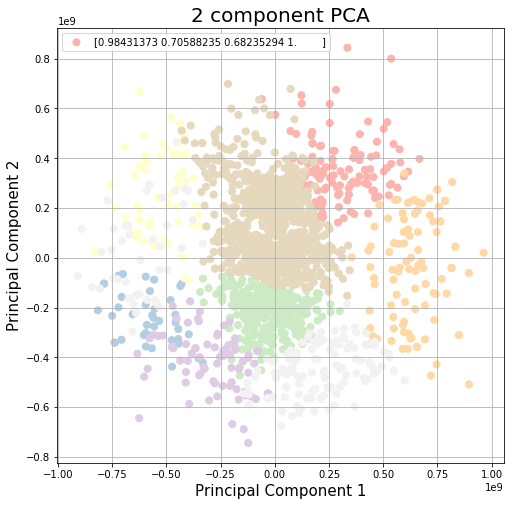

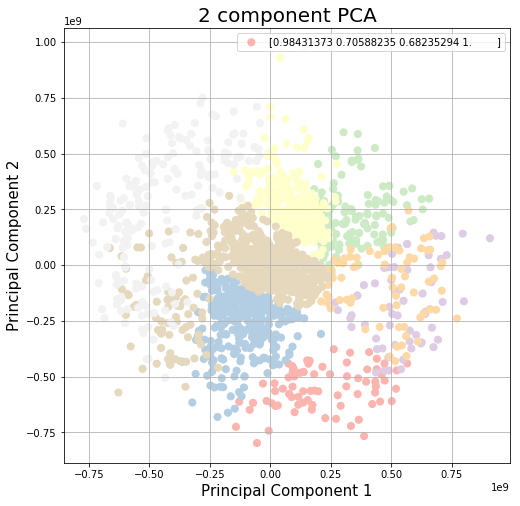

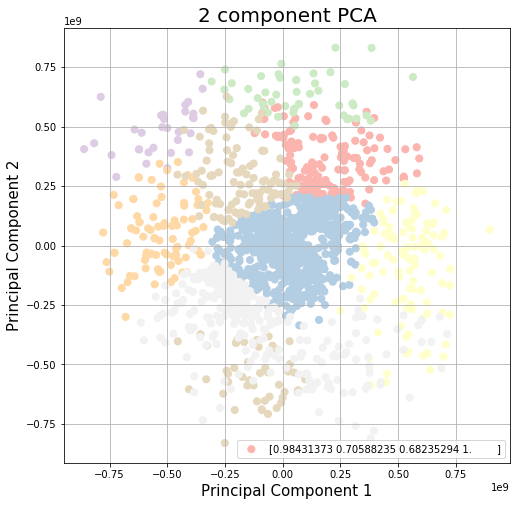

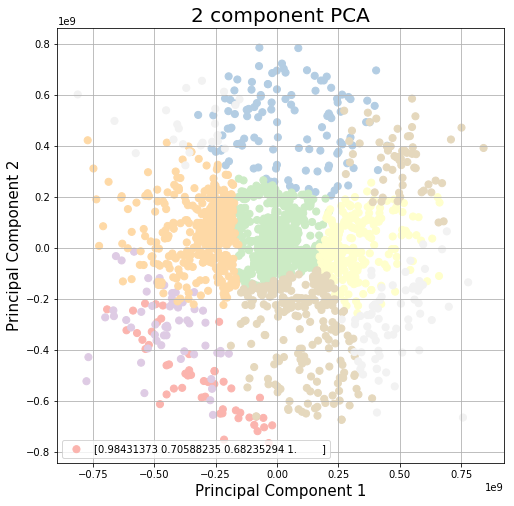

In [0]:
''' train, test '''
import os

emotions = ['ang', 'hap', 'sad', 'neu']
# neu = empty so ignore
LMA_train = pd.read_csv('/content/drive/My Drive/Compsci II/Dissertation Project/paco/train-test/train_data.csv').iloc[:, 1:]

for emotion in emotions:
    print('Finding clusters for emotion ' + emotion)
    df_path = '/content/drive/My Drive/Compsci II/Dissertation Project/paco/train-test/train_' + emotion + '.h5'
    if not os.path.isfile(df_path):
        df = LMA_train.loc[LMA_train['emotion'] == emotion]
        df = flatten_by_frame(df, paco=True)
        # Write pandas dataframe to compressed h5.py file
        df.to_hdf(df_path, key='df', mode='w')
    else:
        df = pd.read_hdf(df_path)
    df_arr = np.array(df)
    generate_lexicon(emotion, df_arr, clusters_dir='/content/drive/My Drive/Compsci II/Dissertation Project/paco/train-test/clusters', left_out='', override_existing_clusters=True)

In [0]:
# import sys
# sys.setrecursionlimit(1000)

In [0]:
# Split into folds
# !unzip '/content/drive/My Drive/Compsci II/Dissertation Project/paco/LMA_features_cross_val.h5.zip' -d '/content/drive/My Drive/Compsci II/Dissertation Project/paco'
import pandas as pd
df = pd.read_csv('/content/drive/My Drive/Compsci II/Dissertation Project/paco/LMA_features_cross_val.csv').iloc[:,1:]
for i in range(10):
  print('Fold ' + str(i))
  df_test_fold_i = df.loc[df['fold']!=i]
  df_path = '/content/drive/My Drive/Compsci II/Dissertation Project/paco/LMA_features_test_fold_' + str(i) + '.csv'
  df_test_fold_i.to_csv(df_path)

Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9


In [0]:
''' Prepare for 10 fold cross val '''
# !unzip '/content/drive/My Drive/Compsci II/Dissertation Project/paco/LMA_features_crossfold.h5.zip' -d '/content/drive/My Drive/Compsci II/Dissertation Project/paco'

# create necessary directories 
import os
if not os.path.isdir('plots'):
  !mkdir plots
if not os.path.isdir('data'):
  !mkdir data

os.chdir('data')
if not os.path.isdir('paco'):
  !mkdir paco
os.chdir('paco')
if not os.path.isdir('clusters'):
  !mkdir clusters

os.chdir('../../')

# load in dataset from drive
# from shutil import copyfile

# src = '/content/drive/My Drive/Compsci II/Dissertation Project/paco/LMA_features_crossfold.h5'
# dst = '/content/data/paco/LMA_features_crossfold.h5'
# copyfile(src, dst)



In [0]:
''' 10 fold cross val '''
from shutil import copyfile
import os
emotions = ['ang', 'hap', 'sad', 'neu']

no_folds = 10

for i in range(no_folds):
    print('Test fold: ' + str(i))
    
    df_path = '/content/drive/My Drive/Compsci II/Dissertation Project/paco/LMA_features_test_fold_' + str(i) + '.csv'
    LMA_train = pd.read_csv(df_path).iloc[:, 1:]
    for emotion in emotions:
        print('Finding clusters for emotion ' + emotion)
        df = LMA_train.loc[LMA_train['emotion'] == emotion]
        df = flatten_by_frame(df, paco=True)
        df_arr = np.array(df)
        clusters_dir='/content/drive/My Drive/Compsci II/Dissertation Project/paco/10_fold_cross_val/cross_val_' + str(i)
        generate_lexicon(emotion, df_arr, clusters_dir=clusters_dir, left_out=str(i), visualise_clusters=False)
        
    print('Copying clusters for fold ' + str(i))
#     fold_files = ['/content/data/paco/clusters/cross_val_' + str(i) + "/clusters_" + str(i) + "_" + emotion + ".npz" for emotion in emotions]
#     for file in fold_files:
#       clusters_path = '/content/data/paco/clusters/cross_val_' + str(i)
#       copyfile(file, '/content/drive/My Drive/Compsci II/Dissertation Project/paco/10_fold_cross_val/' + os.path.basename(file))





Test fold: 0
Finding clusters for emotion ang
Doing clustering
Saving clusters...
Done.
Finding clusters for emotion hap
Doing clustering
Saving clusters...
Done.
Finding clusters for emotion sad
Doing clustering
Saving clusters...
Done.
Finding clusters for emotion neu
Doing clustering
Saving clusters...
Done.
Copying clusters for fold 0
Test fold: 1
Finding clusters for emotion ang
Doing clustering
Saving clusters...
Done.
Finding clusters for emotion hap
Doing clustering
Saving clusters...
Done.
Finding clusters for emotion sad
Doing clustering
Saving clusters...
Done.
Finding clusters for emotion neu
Doing clustering
Saving clusters...
Done.
Copying clusters for fold 1
Test fold: 2
Finding clusters for emotion ang
Doing clustering
Saving clusters...
Done.
Finding clusters for emotion hap
Doing clustering
Saving clusters...
Done.
Finding clusters for emotion sad
Doing clustering
Saving clusters...
Done.
Finding clusters for emotion neu
Doing clustering
Saving clusters...
Done.
Copyi

In [0]:
''' LOSO '''
import shutil
from google.colab import files
emotions = ['ang', 'hap', 'sad', 'neu']
LMA_df = pd.read_csv('/content/drive/My Drive/Compsci II/Dissertation Project/paco/LMA_features_cross_val.csv').iloc[:, 1:]

subjects = ['ale', 'ali', 'alx', 'amc', 'bar', 'boo', 'chr', 'dav', 'din', 'dun', 'ele', 'emm', 'gra', 'ian', 'jan', 'jen', 'jua', 'kat', 'lin', 'mac', 'mar', 'mil', 'ndy', 'pet', 'rac', 'ros', 'she', 'shi', 'ste', 'vas']
for subject in subjects[:20]:
    clusters_dir = '/content/drive/My Drive/Compsci II/Dissertation Project/paco/LOSO/LOSO_' + subject
    if not os.path.isdir(clusters_dir):
      print('Leaving out subject: ' + subject)
      os.mkdir(clusters_dir)
    else:
      print('Skipping')
      continue
      
    LMA_subject = LMA_df.loc[LMA_df['subject'] != subject]
    for emotion in emotions:
        print('Finding clusters for emotion ' + emotion)
        df = LMA_subject.loc[LMA_subject['emotion'] == emotion]
        df = flatten_by_frame(df, paco=True)
        # Write pandas dataframe to compressed h5.py file
        df_arr = np.array(df)
        
          
        generate_lexicon(emotion, df_arr, clusters_dir, left_out=subject, visualise_clusters=False)
        


Leaving out subject: ale
Finding clusters for emotion ang
Doing clustering
Saving clusters...
Done.
Finding clusters for emotion hap
Doing clustering
Saving clusters...
Done.
Finding clusters for emotion sad
Doing clustering
Saving clusters...
Done.
Finding clusters for emotion neu
Doing clustering
Saving clusters...
Done.
Leaving out subject: ali
Finding clusters for emotion ang
Doing clustering
Saving clusters...
Done.
Finding clusters for emotion hap
Doing clustering
Saving clusters...
Done.
Finding clusters for emotion sad
Doing clustering
Saving clusters...
Done.
Finding clusters for emotion neu
Doing clustering
Saving clusters...
Done.
Leaving out subject: alx
Finding clusters for emotion ang
Doing clustering
Saving clusters...
Done.
Finding clusters for emotion hap
Doing clustering
Saving clusters...
Done.
Finding clusters for emotion sad
Doing clustering
Saving clusters...
Done.
Finding clusters for emotion neu
Doing clustering
Saving clusters...
Done.
Leaving out subject: amc


In [0]:
from shutil import copyfile
to_download = ['mar', 'mil', 'ndy', 'pet', 'rac', 'ros', 'she', 'shi', 'ste', 'vas']
files_to_download = ['/content/data/paco/clusters/LOSO_' + subject + '/' + 'clusters_' + subject + '_' + emotion + '.npz' for emotion in emotions for subject in to_download]
for file in files_to_download:
  print(os.path.basename(file))
  copyfile(file, '/content/drive/My Drive/Compsci II/Dissertation Project/paco/LOSO/' + os.path.basename(file)) 

clusters_mar_ang.npz
clusters_mil_ang.npz
clusters_ndy_ang.npz
clusters_pet_ang.npz
clusters_rac_ang.npz
clusters_ros_ang.npz
clusters_she_ang.npz
clusters_shi_ang.npz
clusters_ste_ang.npz
clusters_vas_ang.npz
clusters_mar_hap.npz
clusters_mil_hap.npz
clusters_ndy_hap.npz
clusters_pet_hap.npz
clusters_rac_hap.npz
clusters_ros_hap.npz
clusters_she_hap.npz
clusters_shi_hap.npz
clusters_ste_hap.npz
clusters_vas_hap.npz
clusters_mar_sad.npz
clusters_mil_sad.npz
clusters_ndy_sad.npz
clusters_pet_sad.npz
clusters_rac_sad.npz
clusters_ros_sad.npz
clusters_she_sad.npz
clusters_shi_sad.npz
clusters_ste_sad.npz
clusters_vas_sad.npz
clusters_mar_neu.npz
clusters_mil_neu.npz
clusters_ndy_neu.npz
clusters_pet_neu.npz
clusters_rac_neu.npz
clusters_ros_neu.npz
clusters_she_neu.npz
clusters_shi_neu.npz
clusters_ste_neu.npz
clusters_vas_neu.npz


In [0]:
# Download files
from google.colab import files

!zip -r plots.zip plots
files.download('plots.zip')


  adding: plots/ (stored 0%)
  adding: plots/paco_kmedians_hap.png (deflated 2%)
  adding: plots/paco_kmedians_sad.png (deflated 2%)
  adding: plots/paco_kmedians_ang.png (deflated 2%)
  adding: plots/paco_kmedians_neu.png (deflated 2%)


In [0]:
from google.colab import files

!zip -r '/content/drive/My Drive/Compsci II/Dissertation Project/paco/LOSO.zip' '/content/drive/My Drive/Compsci II/Dissertation Project/paco/LOSO'

  adding: content/drive/My Drive/Compsci II/Dissertation Project/paco/LOSO/ (stored 0%)
  adding: content/drive/My Drive/Compsci II/Dissertation Project/paco/LOSO/clusters_emm_ang.npz (deflated 0%)
  adding: content/drive/My Drive/Compsci II/Dissertation Project/paco/LOSO/clusters_gra_ang.npz (deflated 0%)
  adding: content/drive/My Drive/Compsci II/Dissertation Project/paco/LOSO/clusters_ian_ang.npz (deflated 0%)
  adding: content/drive/My Drive/Compsci II/Dissertation Project/paco/LOSO/clusters_jan_ang.npz (deflated 0%)
  adding: content/drive/My Drive/Compsci II/Dissertation Project/paco/LOSO/clusters_jen_ang.npz (deflated 0%)
  adding: content/drive/My Drive/Compsci II/Dissertation Project/paco/LOSO/clusters_jua_ang.npz (deflated 0%)
  adding: content/drive/My Drive/Compsci II/Dissertation Project/paco/LOSO/clusters_kat_ang.npz (deflated 0%)
  adding: content/drive/My Drive/Compsci II/Dissertation Project/paco/LOSO/clusters_lin_ang.npz (deflated 0%)
  adding: content/drive/My Drive

In [0]:
from google.colab import files
subjects_to_download = ['mar', 'mil', 'ndy', 'pet', 'rac', 'ros', 'she', 'shi', 'ste', 'vas']
emotions = ['hap', 'sad', 'ang', 'neu']
files_to_download = ['/content/drive/My Drive/Compsci II/Dissertation Project/paco/LOSO/clusters_' + subject + '_' + emotion + '.npz' for subject in subjects_to_download for emotion in emotions]
for file in files_to_download:
  files.download(file)


----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 44682, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 721, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

KeyboardInterrupt: ignored